# Set-Up
System dependencies

In [ ]:
# be able to take input from a server (sent from mobile device) or from the camera sensor.

In [2]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# importing dependencies
import cv2
from matplotlib import pyplot as plt
import imghdr

/var/folders/95/jvxsqj5950j0xkyn6vwwy_cc0000gn/T/ipykernel_5983/2556092084.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
# Set the data directory
data_dir = 'data'

In [8]:
# telling the computer what the image extensions are
image_exts = ['jpeg', 'jpg', 'bmp', 'png'] 

In [9]:
os.listdir(data_dir) # should return benign and malignant ; 
# returns folders inside of the data dir

['.DS_Store', 'malignant', 'benign']

In [10]:
# os.listdir(os.path.join(data_dir, 'malignant'))
# os.listdir(os.path.join(data_dir, 'benign'))
# returns every image within the folder

['63.jpg',
 '823.jpg',
 '1409.jpg',
 '189.jpg',
 '77.jpg',
 '837.jpg',
 '1353.jpg',
 '1435.jpg',
 '1421.jpg',
 '1347.jpg',
 '638.jpg',
 '1390.jpg',
 '604.jpg',
 '162.jpg',
 '176.jpg',
 '88.jpg',
 '610.jpg',
 '1384.jpg',
 '1179.jpg',
 '1637.jpg',
 '1151.jpg',
 '1145.jpg',
 '1623.jpg',
 '348.jpg',
 '360.jpg',
 '406.jpg',
 '1192.jpg',
 '1186.jpg',
 '412.jpg',
 '374.jpg',
 '1019.jpg',
 '599.jpg',
 '1743.jpg',
 '1025.jpg',
 '1031.jpg',
 '1757.jpg',
 '228.jpg',
 '214.jpg',
 '1780.jpg',
 '572.jpg',
 '566.jpg',
 '1794.jpg',
 '200.jpg',
 '957.jpg',
 '1569.jpg',
 '943.jpg',
 '1227.jpg',
 '1541.jpg',
 '1555.jpg',
 '1233.jpg',
 '994.jpg',
 '758.jpg',
 '980.jpg',
 '770.jpg',
 '1582.jpg',
 '1596.jpg',
 '764.jpg',
 '1597.jpg',
 '765.jpg',
 '771.jpg',
 '1583.jpg',
 '981.jpg',
 '759.jpg',
 '995.jpg',
 '1554.jpg',
 '1232.jpg',
 '1226.jpg',
 '1540.jpg',
 '1568.jpg',
 '942.jpg',
 '956.jpg',
 '567.jpg',
 '201.jpg',
 '1795.jpg',
 '1781.jpg',
 '215.jpg',
 '573.jpg',
 '229.jpg',
 '1030.jpg',
 '1756.jpg',
 '17

In [11]:
for image_class in os.listdir(data_dir):
    print(image_class) # loops thru directories

.DS_Store
malignant
benign


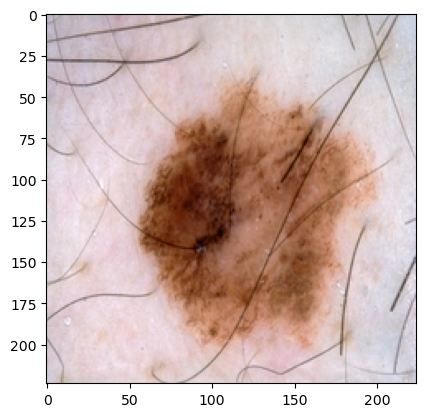

In [18]:
img = cv2.imread(os.path.join('data', 'malignant', '267.jpg'))
# type(img) numpy array
# img.shape # 3 means is is a colored image long x high
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # this will display img

In [16]:
for image_class in os.listdir(data_dir):
    if image_class != '.DS_Store':
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try:
                img = cv2.imread(image_path) # opens image
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print("image contains an unknown extension: {}".format(image_path))
                    os.remove(image_path) # deletes files from the dir if they r weird
            except Exception as e:
                print('uh oh! issue with image : {}'.format(image_path))

In [19]:
tf.data.Dataset # allows us to build data pipelines
# uses Keras utility

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [20]:
import numpy as np

In [21]:
data = tf.keras.utils.image_dataset_from_directory('data')
# builds image data set and performs preprocessing

Found 3297 files belonging to 2 classes.


In [22]:
# note that data is a generator; convert 
# it into a numpy iterator.
data_iterator = data.as_numpy_iterator()

In [23]:
# grabbing one batch/accessing it
batch = data_iterator.next()

In [25]:
len(batch)
# 2 parts to this data set, 
#images and labels

2